<img src="spam.jpg" />

# Spam Classifier

### Objectif : Concevoir un classifieur de détection automatique de SPAM.

La collection SMS Spam est un ensemble de messages SMS marqués qui ont été collectés pour la recherche sur les SMS Spam. Elle contient un ensemble de messages SMS en anglais de 5 574 messages, étiquetés selon qu'ils sont ham (légitimes) ou spam.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import string

In [2]:
df = pd.read_csv('spam.csv',encoding = "latin-1")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
df.drop(['Unnamed: 2', 'Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
df.rename(columns={"v1": "target", "v2": "text"},inplace=True)

In [5]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.describe()

,target,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


# EDA + Features extraction

In [7]:
df['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

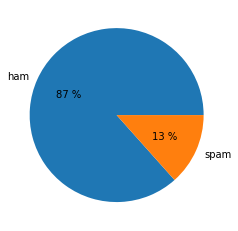

In [8]:
plt.pie(df["target"].value_counts(),labels=["ham","spam"],autopct="%.0f %%")
plt.show()

### Valeurs en double

In [9]:
df.duplicated().value_counts()

False    5169
True      403
dtype: int64

In [10]:
df.drop_duplicates(inplace=True) # (pour Noli,inplace supprimer directement sur la df)

In [11]:
df.duplicated().value_counts() # Verification apres suppression

False    5169
dtype: int64

# Features extraction

#### Longueur du texte

In [12]:
df['length'] = df['text'].str.len()

In [13]:
df.head() # Verification

,target,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


#### Nombre de mots

In [14]:
df['words_count'] = df['text'].apply(lambda x: len(x.split(" ")))

In [15]:
df.head() # Verification

,target,text,length,words_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13


#### Nombre de majuscules

In [16]:
df['uppercases_count'] = df['text'].str.findall(r'[A-Z]').str.len()

In [17]:
df.head() # Verification

,target,text,length,words_count,uppercases_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3
1,ham,Ok lar... Joking wif u oni...,29,6,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10
3,ham,U dun say so early hor... U c already then say...,49,11,2
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2


#### Nombre de minuscules

In [18]:
df['lowercases_count'] = df['text'].str.findall(r'[a-z]').str.len()

In [19]:
df.head()

,target,text,length,words_count,uppercases_count,lowercases_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80
1,ham,Ok lar... Joking wif u oni...,29,6,2,16
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87
3,ham,U dun say so early hor... U c already then say...,49,11,2,31
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45


#### Presence d'un numéro de téléphone

In [20]:
def isPhoneNumberInText(txt):
    if bool(re.search("(\d{2})", txt)):
        return 1
    else:
        return 0

In [21]:
df['phone_number_sequence'] = df['text'].map(isPhoneNumberInText)

In [22]:
df.head() # Verification

,target,text,length,words_count,uppercases_count,lowercases_count,phone_number_sequence
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87,1
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45,0


In [23]:
df.groupby(['target'])['phone_number_sequence'].sum()

target
ham      97
spam    580
Name: phone_number_sequence, dtype: int64

Text(0.5, 1.0, 'le rapport ham/spam quand il y a au mois 2 chiffres de suites')

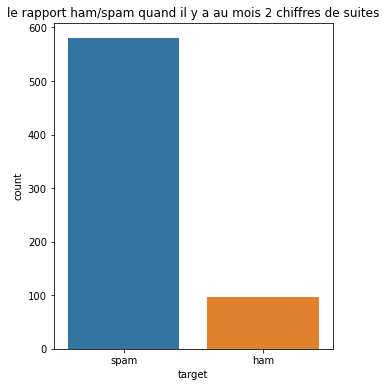

In [24]:
df1 = df[df['phone_number_sequence'] == 1]
plt.figure(figsize=(5,6),)
sns.countplot(x=df1['target']).set_title('le rapport ham/spam quand il y a au mois 2 chiffres de suites')

#### Présence d'une url ou d'un mail

In [25]:
def isUrlMailInText(txt):
    if bool(re.search("\.[a-z]{2,3}(\.|\s|$)|(https?:\/\/|www\.)[a-zA-Z0-9-_\.]+", txt)):
        return 1
    else:
        return 0

In [26]:
df['url_or_mail'] = df['text'].map(isUrlMailInText)

In [27]:
df.head() # Verification

,target,text,length,words_count,uppercases_count,lowercases_count,phone_number_sequence,url_or_mail
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87,1,0
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45,0,0


In [28]:
df.groupby(['target'])['url_or_mail'].sum()

target
ham     175
spam    116
Name: url_or_mail, dtype: int64

Text(0.5, 1.0, "Rapport ham/spam si présence d'une url")

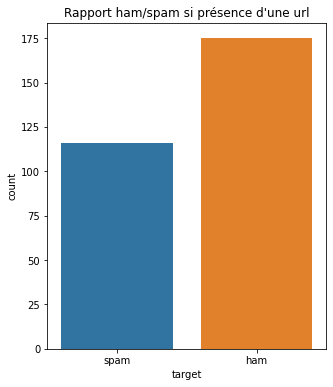

In [29]:
df1 = df[df['url_or_mail'] == 1]
plt.figure(figsize=(5,6),)
sns.countplot(x=df1['target']).set_title('Rapport ham/spam si présence d\'une url')

#### Nombre de caractères spéciaux

In [30]:
def countSpecialCharInText(txt):
    return len(re.findall("[$&+:;=?@#|'<>^*()%!-]", txt))

In [31]:
df['special_char_count'] = df['text'].map(countSpecialCharInText)

In [32]:
df.head() # Verification

,target,text,length,words_count,uppercases_count,lowercases_count,phone_number_sequence,url_or_mail,special_char_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,80,0,0,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,16,0,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,10,87,1,0,5
3,ham,U dun say so early hor... U c already then say...,49,11,2,31,0,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,2,45,0,0,1


Text(0.5, 1.0, 'Moyenne ham/spam des carac.spéciaux')

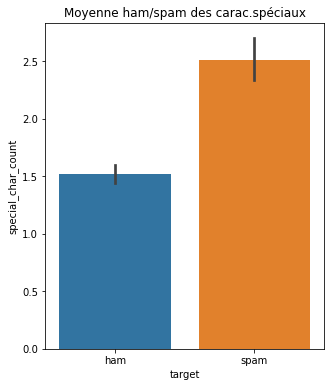

In [33]:
plt.figure(figsize=(5,6),)
sns.barplot(data = df, x="target",y="special_char_count").set_title('Moyenne ham/spam des carac.spéciaux')

In [34]:
df.to_csv('view.csv')

# Wordcloud

#### Préparation

In [35]:
def text_cleaning(text):
    text = str(text).lower() #Converting text into lowercase
    text = re.sub('\[.*?\]','',text) #Removing square brackets from the text
    text = re.sub('https?://\S+|www\.\S+', '', text) #Removing links starting with (https or www)
    text = re.sub('<.*?>+','',text) #Removing <"text"> type of text
    text = re.sub("[%s]" % re.escape(string.punctuation),'',text) #Removing punctuations
    text = re.sub("\n",'',text) #Removing new lines
    text = re.sub('\w*\d\w*','',text) #Removing alphanumeric numbers
    text = re.sub('û÷',"'",text) # Remplacement caractères non encodés
    text = re.sub('åõ',"'",text) # Remplacement caractères non encodés
    return(text)

In [36]:
df['text'] = df['text'].apply(text_cleaning)

In [37]:
strHam = ""
strSpam = ""

for idx, series in df.iterrows():
    if series['target'] == 'ham': 
        strHam += series['text']
        strHam += " "
    else:
        strSpam += series['text']
        strSpam += " "

In [38]:
df['text'].head(25)

0     go until jurong point crazy available only in ...
1                               ok lar joking wif u oni
2     free entry in  a wkly comp to win fa cup final...
3           u dun say so early hor u c already then say
4     nah i dont think he goes to usf he lives aroun...
5     freemsg hey there darling its been  weeks now ...
6     even my brother is not like to speak with me t...
7     as per your request melle melle oru minnaminun...
8     winner as a valued network customer you have b...
9     had your mobile  months or more u r entitled t...
10    im gonna be home soon and i dont want to talk ...
11    six chances to win cash from  to  pounds txt  ...
12    urgent you have won a  week free membership in...
13    ive been searching for the right words to than...
14                    i have a date on sunday with will
15    xxxmobilemovieclub to use your credit click th...
16                                 oh kim watching here
17    eh u remember how  spell his name yes i di

In [39]:
strHam

"go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat ok lar joking wif u oni u dun say so early hor u c already then say nah i dont think he goes to usf he lives around here though even my brother is not like to speak with me they treat me like aids patent as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press  to copy your friends callertune im gonna be home soon and i dont want to talk about this stuff anymore tonight k ive cried enough today ive been searching for the right words to thank you for this breather i promise i wont take your help for granted and will fulfil my promise you have been wonderful and a blessing at all times i have a date on sunday with will oh kim watching here eh u remember how  spell his name yes i did he v naughty make until i v wet fine if that's the way u feel that's the way its gota b is that seriously how you spell his name i\x89'm going

<Figure size 432x288 with 0 Axes>

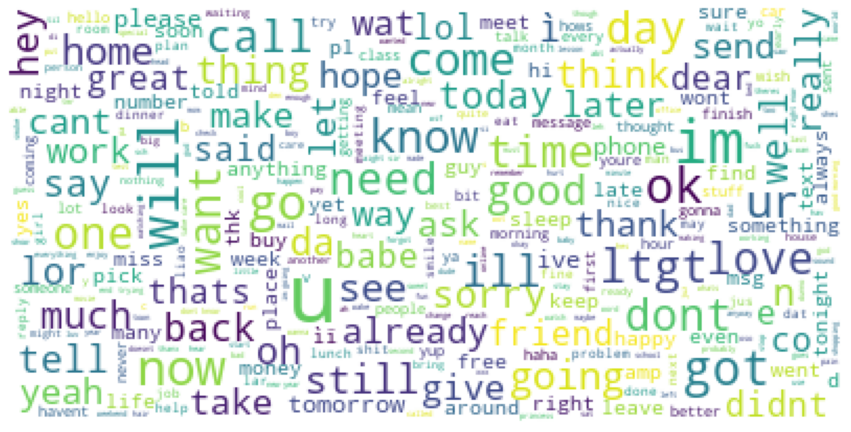

In [40]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud().generate(strHam)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(strHam),max_font_size=40, relative_scaling=.5).generate(strHam)
plt.figure()
plt.figure( figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Wordcloud des Spam

<Figure size 432x288 with 0 Axes>

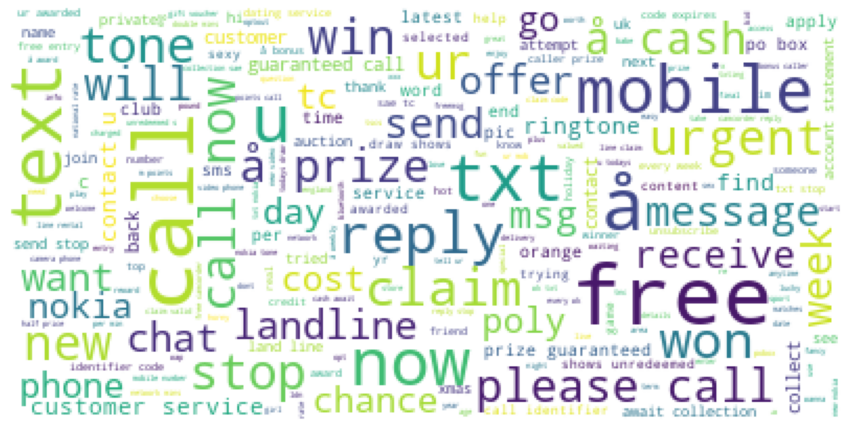

In [41]:
# Generate a word cloud image
wordcloud = WordCloud().generate(strSpam)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(strSpam),max_font_size=40, relative_scaling=.5).generate(strSpam)
plt.figure()
plt.figure( figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [42]:
prize, urgent, free, mobile, please call, call now, cash, chat, win, txt, now, reply, phone, new, now, call, tone, claim, won, chance 

SyntaxError: invalid syntax (2499323779.py, line 1)

In [44]:
wordsList = ['prize','urgent','free','mobile','please','cash','chat','win','txt','reply','phone','new','now','call','tone','claim','won','chance']

In [45]:
def countWordsInText(txt):
    res = 0
    nb = 0
    for i in wordsList:
        nb += len(re.findall(r"\b" + i + r"\b", txt))
            
    if nb > 3:
        res = 1
    else:
        res = 0

    return res

In [46]:
for r in df['text']:
    print("-- ",r,countWordsInText(r))

--  go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat 0
--  ok lar joking wif u oni 0
--  free entry in  a wkly comp to win fa cup final tkts  may  text fa to  to receive entry questionstd txt ratetcs apply  0
--  u dun say so early hor u c already then say 0
--  nah i dont think he goes to usf he lives around here though 0
--  freemsg hey there darling its been  weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send å£ to rcv 0
--  even my brother is not like to speak with me they treat me like aids patent 0
--  as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press  to copy your friends callertune 0
--  winner as a valued network customer you have been selected to receivea å£ prize reward to claim call  claim code  valid  hours only 1
--  had your mobile  months or more u r entitled to update to the latest colour mobiles with camer

--  look at the fuckin time what the fuck you think is up 0
--  yo guess what i just dropped 0
--  carlos says hell be at mu in  ltgt  minutes 0
--  im in office now  i will call you  ltgt  min 0
--  geeee  i miss you already you know  your all i can think about fuck i cant wait till next year when we will be together  loving kiss 0
--  yun ahthe ubi one say if ì wan call by tomorrowcall  look for ireneere only got  ubi cresubi tech  for   daysì¬n 0
--  ugh gotta drive back to sd from la my butt is sore 0
--   of july 0
--  hi im having the most relaxing time ever we have to get up at  every day was the party good the other night i get home tomorrow at  0
--  up to ì ìï wan come then come lor but i din c any stripes skirt 0
--  the xmas story is peace the xmas msg is love the xmas miracle is jesus hav a blessed month ahead amp wish u merry xmas 0
--  i cant i dont have her number 0
--  change again its e one next to escalator 0
--  yetunde im in class can you not run water on it to mak

--  hey  i want you  i crave you  i miss you  i need you  i love you ahmad saeed al hallaq  0
--  is there any training tomorrow 0
--  urgent your mobile no  won a å£ bonus caller prize on  this is the  attempt to reach you call  asap   1
--  pass dis to all ur contacts n see wat u get redim in luv wid u blueu put a smile on my face purpleu r realy hot pinku r so swt orangei thnk i lyk u greeni realy wana go out wid u yelowi wnt u bck blackim jealous of u browni miss you nw plz giv me one color 0
--  cos daddy arranging time c wat time fetch ì mah 0
--  then you are eldest know 0
--  whos there say hi to our drugdealer 0
--  its hard to believe things like this all can say lie but think twice before saying anything to me 0
--  eerie nokia tones  rply tone title to  eg tone dracula to  titles ghost addamsfa munsters exorcist twilight     0
--  sexy singles are waiting for you text your age followed by your gender as wither m or f  for gay men text your age followed by a g  0
--  good ni

--  get a brand new mobile phone by being an agent of the mob plus loads more goodies for more info just text mat to  0
--  ok so april cant wait 0
--  boy you best get yo ass out here quick 0
--  ay wana meet on satì wkg on sat 0
--  im now but have to wait till  for the bus to pick me 0
--  apart from the one i told you about yesterday 0
--  ok lor but buy wat 0
--  somebody should go to andros and steal ice 0
--  don know i didt msg him recently 0
--  take us out shopping and mark will distract isaiahd 0
--  mum hope you are having a great day hoping this text meets you well and full of life have a great day abiola 0
--  there is no sense in my foot and penis 0
--  okay but i thought you were the expert 0
--  deep sigh  i miss you   i am really surprised you havent gone to the net cafe yet to get to me  dont you miss me 0
--  ssi thinl role is like sachinjust standing others have to hit 0
--  have a great trip to india and bring the light to everyone not just with the project but wi

--  mmmmmm  i love youso much ahmad  i cant wait for this year to begin as every second takes me closer to being at your side happy new year my love 0
--  pls whats the full name of jokes school cos fees in university of florida seem to actually be  ltgt k pls holla back 0
--  ok but they said ive got wisdom teeth hidden inside n mayb need  remove 0
--  and pls pls drink plenty plenty water 0
--  how are you doing hows the queen are you going for the royal wedding 0
--  hes in lag thats just the sad part but we keep in touch thanks to skype 0
--  ok lor then we go tog lor 0
--  two teams waiting for some players 0
--  can ì send me a copy of da report 0
--  swhrt how u deyhope ur ok tot about u  n misstake care 0
--  ok da i already planned i wil pick you 0
--  urgent please call  your abta complimentary  spanish holiday or å£ cash await collection sae tcs box      1
--  i just really need shit before tomorrow and i know you wont be awake before like  0
--  im good have you registered 

--  thanks for being there for me just to talk to on saturday you are very dear to me i cherish having you as a brother and role model 0
--  pls clarify back if an open return ticket that i have can be preponed for me to go back to kerala 0
--  natalie  is inviting you to be her friend reply  or  see her  stop send stop frnd to  0
--  she ran off with a younger man we will make pretty babies together  0
--  jamster to get your free wallpaper text heart to  now tc apply  only need help call  0
--  o ic lol should play  doors sometime yo 0
--  dunno my dad said he coming home  bring us out  lunch yup i go w u lor i call u when i reach school lor 0
--  desires u going to doctor  liver and get a bit stylish get ur hair managed thats it 0
--  hmmmstill we dont have opener 0
--  yeah so basically any time next week you can get away from your mom amp get up before  0
--  i will vote for wherever my heart guides me 0
--  with my sis lor we juz watched italian job 0
--  tick tick tick  where ar

In [48]:
df['words_fateful_count'] = df['text'].map(countWordsInText)

In [49]:
df.groupby(['target'])['words_fateful_count'].sum()

target
ham       5
spam    176
Name: words_fateful_count, dtype: int64

# Preprocessing

In [57]:
df.head()

,target,length,words_count,uppercases_count,lowercases_count,phone_number_sequence,url_or_mail,special_char_count,words_fateful_count
0,ham,111,20,3,80,0,0,0,0
1,ham,29,6,2,16,0,0,0,0
2,spam,155,28,10,87,1,0,5,0
3,ham,49,11,2,31,0,0,0,0
4,ham,61,13,2,45,0,0,1,0


In [65]:
df['special_char_count'].value_counts()

0     1954
1     1361
2      725
3      408
4      244
5      191
6      119
7       52
8       29
9       21
10      14
11      10
12       9
14       5
16       5
13       5
15       3
19       2
22       2
21       2
24       1
92       1
23       1
35       1
34       1
17       1
31       1
18       1
Name: special_char_count, dtype: int64

In [54]:
df.drop('text',axis=1,inplace=True)

In [61]:
from sklearn.preprocessing import LabelEncoder

# target preprocessing
lb_encod = LabelEncoder()
y = lb_encod.fit_transform(df['target'])

# Normalise

In [ ]:
# Selection des colonnes a normaliser
column_num = df['length','words_count','uppercases_count','lowercases_count','special_char_count','words_fateful_count']

In [ ]:
transfo_num = Pipeline(steps=[
    ('scaling', MinMaxScaler())
])

# Pipeline ML